# 14.1: Systematic search

In [1]:
import numpy as np
from openbabel import openbabel as ob
import nglview as nv
import scipy
mol = ob.OBMol()
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("pdb","pdb")
    conv.ReadFile(mol, infile)
    conv.WriteFile(mol, outfile)
to_pdb("alanine_dipeptide.pdb","gg.pdb")
view = nv.show_structure_file("gg.pdb")
view.add_representation('label', labelType='serial', backgroundColor='black', showBackground=True)
import scipy.ndimage as filters
import scipy.ndimage as morphology
def detect_local_minima(arr):
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    background = (arr==0)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)
def detect_local_maxima(arr):
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    background = (arr==0)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima)       

view

NGLWidget()

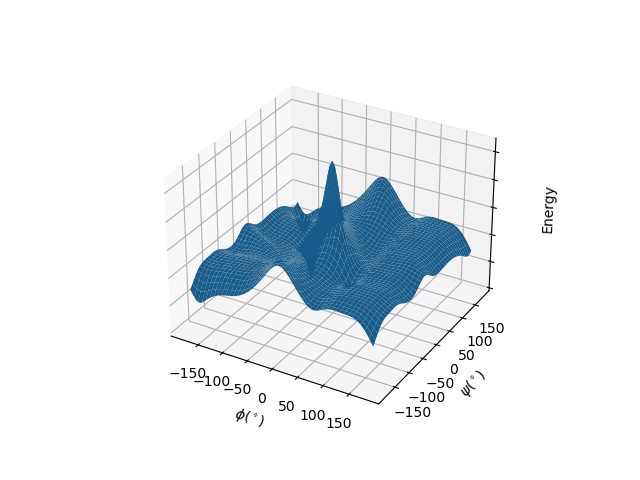

In [2]:
#Systematic search
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform the systematic search
torsions = [[5, 7, 9, 15], [7, 9, 15, 17]]

# Generate a mesh of grid points for the two dihedral angles
theta1 = np.linspace(-np.pi, np.pi, 361)
theta2 = np.linspace(-np.pi, np.pi, 361)

theta1, theta2 = np.meshgrid(theta1, theta2)
energies = np.zeros_like(theta1)

# Calculate the energy on the grid
ff = ob.OBForceField_FindType("MMFF94")
for i in range(len(theta1)):
    for j in range(len(theta2)):
        mol.SetTorsion(*torsions[0], theta1[i, j])
        mol.SetTorsion(*torsions[1], theta2[i, j])
        ff.Setup(mol)
        energies[i, j] = ff.Energy()
min_energy = np.min(energies)
energies -= min_energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta1*180.0/np.pi, theta2*180.0/np.pi, np.log10(energies + 0.1)) # Avoid zero for log scale
ax.set_zticklabels([])
ax.set_xlabel(r'$\phi (^\circ)$')
ax.set_ylabel(r'$\psi (^\circ)$')
ax.set_zlabel('Energy')
plt.show()

In [3]:
#Getting and printing local minima locations
local_minima_locations = detect_local_minima(energies)
print([local_minima_locations])

[(array([  0,   0,   3, 118, 128, 131, 208, 233, 244, 345, 349, 360],
      dtype=int64), array([ 18, 360, 246, 249,  15, 360, 240, 360,  99,  21, 360, 246],
      dtype=int64))]


### The Most prominent minima are:
- $\phi_1 =-75^\circ$ and $\psi_1 = 60^\circ$
- $\phi_2 =-100^\circ$ and $\psi_2 =170^\circ$

In [4]:
from IPython.display import display
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("pdb","pdb")
    conv.ReadFile(mol, infile)
    mol.SetTorsion(*torsions[0], (-75/180)*np.pi)
    mol.SetTorsion(*torsions[1], ((60)/180)*np.pi)
    conv.WriteFile(mol, outfile)
to_pdb("alanine_dipeptide.pdb","gg.pdb")
view = nv.show_structure_file("gg.pdb")
from IPython.display import display
def to_pdb(infile,outfile):
    conv = ob.OBConversion()
    conv.SetInAndOutFormats("pdb","pdb")
    conv.ReadFile(mol, infile)
    mol.SetTorsion(*torsions[0], ((-100)/180)*np.pi)
    mol.SetTorsion(*torsions[1], ((170)/180)*np.pi)
    conv.WriteFile(mol, outfile)
to_pdb("alanine_dipeptide.pdb","gg.pdb")
view2 = nv.show_structure_file("gg.pdb")
display(view)
display(view2)



NGLWidget()

NGLWidget()

# 14.2: MD

In [5]:
# Simulation
from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
temperature = 298 # Kelvin
pdb = PDBFile('system.pdb')
forcefield = ForceField("amber14/protein.ff14SB.xml", "amber14/tip3p.xml")
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer)
integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 1*femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

# Perform NVT simulation
simulation.reporters.append(DCDReporter('NVT.dcd', 500)) # Store trajectory using the dcd binary format
simulation.reporters.append(StateDataReporter("NVT.txt", 500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
simulation.step(5000)

# Setting the pressure
system.addForce(MonteCarloBarostat(1*bar, temperature*kelvin))
state = simulation.context.getState(getPositions=True, getVelocities=True)
simulation.context.reinitialize()
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocities(state.getVelocities())

# Perform NPT simulation
simulation.reporters[0] = DCDReporter('NPT.dcd', 500)
simulation.reporters[1] = StateDataReporter("NPT.txt", 500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
simulation.step(5000000)

# 14.3: Trajectory Analysis

In [6]:
# First display the water box
import nglview as nv
import mdtraj as md
water = md.load("system.pdb")
view = nv.show_mdtraj(water)
view.add_representation("licorice")
view.parameters = {"cameraType": "orthographic"}
view.center()
view

NGLWidget()

#### We can see the simulation stabilized after about $26$ frames, since we have about 10,000 frame. We will remove the first $100$ frame to be safe. This removal because of how far away the molecule from each other at the beginning, waiting until it disappears ensures stability of density and temperature

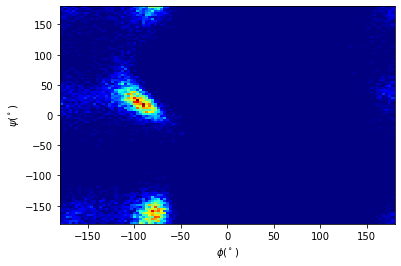

In [1]:
# Histo
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
traj = md.load("NPT.dcd", top="system.pdb")
traj = traj[100:] # Excludeing the first 100 frames from the trajectory
phi = md.compute_dihedrals(traj, [[5, 7, 9, 15]])*180/np.pi
phi = np.squeeze(phi)
psi = md.compute_dihedrals(traj, [[7, 9, 15, 17]])*180/np.pi
psi = np.squeeze(psi)
plt.hist2d(phi, psi, bins=(110, 110), cmap=plt.cm.jet)
plt.xlabel(r'$\phi (^\circ)$')
plt.ylabel(r'$\psi (^\circ)$')
plt.show()


# 14.4: Comments
We can see that the two results almost agrees to one of the prominent minima we got from MC ($\phi_1 =-75^\circ$ and $\psi_1 = 60^\circ$), the other minima exist in MC as well but were not prominent. So it is fair to say the results were consistent.